# Hotspot Detection
This notebook creates a RAG that answers queries across different topics and records feedback function scores across each topic. The resulting dashboard then further analyzes the topics - known as hotspots - that led to comparatively lower feedback function scores. In the notebook, pre-determined topics were attached to each query as query metadata when executing the TruLens recording, but for custom use, you can attach custom topics or categories in the "Topic" attribute of the query metadata.

In [1]:
#set up openAI key in the environment
import os
#os.environ["OPENAI_API_KEY"] = "..."

In [2]:
#package installation - if necessary
#!pip install datasets
#!pip install trulens_eval
#!pip install openai
#!pip install langchain_community
#!pip install "ipython>=8.12.0" "ipywidgets>=8.0.6"

## Part 1 - Generating queries across 5 topics of interest and matching them to each topic
This section has two subparts. Part 1 reads queries from HuggingFace's SQUAD Dataset, where each query has its own pre-assigned context and topic, and stores 500 of these queries across 5 random topics in a dataframe. Part 2 turns this dataframe into a dictionary whose keys are topics and values are (question, context) pairs belonging to that topic. This dictionary will then be used to assign topics to the recording metadata for each query as it's being recorded. If you don't want to generate a new collection of 500 queries each time running this notebook, skip straight to part 2 - which reads the existing dataframe saved locally.

You can skip this whole section and move to the RAG Creation if you have custom queries and metadata to attach to each query. Make sure to set the metadata to the custom metadata in the Recording Process


### Subsection 1 - Finding 50 queries across 5 topics from the HuggingFace SQUAD Dataset

In [3]:
#load SQUAD dataset from huggingface
from datasets import load_dataset
dataset = load_dataset("rajpurkar/squad_v2")

In [4]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [5]:
#datasets in huggingface often have splits, so we need to retrieve the split names
from datasets import get_dataset_split_names
get_dataset_split_names("rajpurkar/squad_v2")

['train', 'validation']

In [6]:
#take just the train split - which has the 130k rows of data that we want
dataset = load_dataset("rajpurkar/squad_v2", split = 'train')

In [7]:
#turn dataset into a dataframe
import pandas as pd
df = pd.DataFrame(dataset)

In [8]:
df.head()

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': ['late 1990s'], 'answer_start': [276]}"


In [9]:
#scramble the dataset and take 0.01% of the 130k rows - now the dataset has different topics and has 1303 rows
scrambled_df = df.sample(frac = 0.01)
scrambled_df

,id,title,context,question,answers
2552,5ad227efd7d075001a428552,Spectre_(2015_film),The ownership of the Spectre organisation—orig...,Who became a producer on the 1985 film Thunder...,"{'text': [], 'answer_start': []}"
128322,5734173b4776f4190066184f,Montana,"East of the divide the Missouri River, which i...",What rivers form the Missouri River?,"{'text': ['Jefferson, Madison and Gallatin riv..."
1770,56ce750daab44d1400b887b3,IPod,"In mid-2015, a new model of the iPod Touch was...",What type of processor does the current iPod T...,"{'text': ['A8'], 'answer_start': [230]}"
65690,57269c97708984140094cbbc,Norfolk_Island,Sir John Call argued the advantages of Norfolk...,Who proposed the idea to include Norfolk Islan...,"{'text': ['John Call'], 'answer_start': [217]}"
109458,5a8c424cfd22b3001a8d8665,Database,"For instance, a common use of a database syste...",What happens to full data fields in a navigati...,"{'text': [], 'answer_start': []}"
...,...,...,...,...,...
95066,572a33f0af94a219006aa894,CBC_Television,Under the CBC's current arrangement with Roger...,Where are affiliates of HNIC aired?,{'text': ['a separate CRTC-licensed part-time ...
56237,5a67d93ff038b7001ab0c496,Film_speed,The noise-based speed is defined as the exposu...,What is the signal-to-noise ration?,"{'text': [], 'answer_start': []}"
53250,57260b4389a1e219009ac184,Clothing,Clothing can and has in history been made from...,What variety has there been in the materials o...,"{'text': ['very wide'], 'answer_start': [49]}"
50134,57264b0f5951b619008f6f31,Freemasonry,There is no clear mechanism by which these loc...,What is the oldest Masonic Lodge in the world?,{'text': ['the Lodge of Edinburgh (Mary's Chap...


In [10]:
#get the first 5 unique topics of this scrambled dataset
unique_titles = scrambled_df['title'].unique()[0:5]
unique_titles_list = list(unique_titles)
unique_titles_list

['Spectre_(2015_film)', 'Montana', 'IPod', 'Norfolk_Island', 'Database']

In [11]:
#get all the rows of the original dataset that relate to the 5 topics of unique list above
unique_df = df[df['title'].isin(unique_titles_list)]
unique_df

,id,title,context,question,answers
1741,56cc55856d243a140015ef0a,IPod,The iPod is a line of portable media players a...,Which company produces the iPod?,"{'text': ['Apple'], 'answer_start': [105]}"
1742,56cc55856d243a140015ef0b,IPod,The iPod is a line of portable media players a...,When was the original iPod released?,"{'text': ['October 23, 2001'], 'answer_start':..."
1743,56cc55856d243a140015ef0c,IPod,The iPod is a line of portable media players a...,How many different types of iPod are currently...,"{'text': ['three'], 'answer_start': [302]}"
1744,56cc55856d243a140015ef0d,IPod,The iPod is a line of portable media players a...,What kind of device is the iPod?,"{'text': ['portable media players'], 'answer_s..."
1745,56cc55856d243a140015ef0e,IPod,The iPod is a line of portable media players a...,The iPod Touch uses what kind of interface?,"{'text': ['touchscreen'], 'answer_start': [400]}"
...,...,...,...,...,...
128408,5734296dd058e614000b6a6e,Montana,When the U.S. entered World War II on December...,How many Montanans entered the miltary in the ...,"{'text': ['40,000-plus'], 'answer_start': [176]}"
128409,5734296dd058e614000b6a6f,Montana,When the U.S. entered World War II on December...,How many Montanans joined the military in the ...,"{'text': ['over 57,000'], 'answer_start': [279]}"
128410,5734296dd058e614000b6a70,Montana,When the U.S. entered World War II on December...,About how many Montanans died in the war?,"{'text': ['At least 1500'], 'answer_start': [6..."
128411,5734296dd058e614000b6a71,Montana,When the U.S. entered World War II on December...,Who trained at the military grounds in Montana?,"{'text': ['First Special Service Force or ""Dev..."


In [12]:
#scramble the unique dataset once more, and take the first 50 rows - so we have a mix of queries from these 5 topics to choose from
unique_df = unique_df.sample(frac = 1.0)
final_df = unique_df.head(50)
final_df

,id,title,context,question,answers
2835,5ad2446bd7d075001a428a58,Spectre_(2015_film),Spectre opened in Germany with $22.45 million ...,North Korea opened to how many million?,"{'text': [], 'answer_start': []}"
2646,5ad22c77d7d075001a428612,Spectre_(2015_film),In March 2013 Mendes said he would not return ...,Who became the first director to oversee three...,"{'text': [], 'answer_start': []}"
65886,5726be37dd62a815002e8f1b,Norfolk_Island,The island is subject to separate immigration ...,What must Australian and New Zealand citizens ...,{'text': ['pass a police check and be able to ...
1908,56cc89c46d243a140015f012,IPod,"At the time the store was introduced, purchase...",By what time did Apple project its entire cata...,"{'text': ['April 2009'], 'answer_start': [987]}"
109555,5a8c8a11fd22b3001a8d8a5f,Database,Having produced a conceptual data model that u...,What terms are no longer used interchangeably?,"{'text': [], 'answer_start': []}"
2695,56cdf52c62d2951400fa69ca,Spectre_(2015_film),"Following filming in Mexico, and during a sche...",Where did Craig go to deal with his injury?,"{'text': ['New York'], 'answer_start': [78]}"
2787,5ad241d7d7d075001a428984,Spectre_(2015_film),"To promote the film, production continued the ...",On whose unofficial social media account did p...,"{'text': [], 'answer_start': []}"
1931,56cca2066d243a140015f043,IPod,"In September 2006, the iTunes Store began to o...",Which version of iTunes was introduced with th...,"{'text': ['iTunes 7'], 'answer_start': [100]}"
1858,56cc81246d243a140015efc6,IPod,Many accessories have been made for the iPod l...,What is the name of an Apple-produced iPod acc...,"{'text': ['iPod Hi-Fi'], 'answer_start': [128]}"
65757,5a81b4a831013a001a334d98,Norfolk_Island,Norfolk Island is located in the South Pacific...,What is the name of the mountain at Norfolk Is...,"{'text': [], 'answer_start': []}"


In [13]:
final_df.to_csv('df with 50 rows of 5 unique topics', index = False)

### Subsection 2 - Turning the dataframe of 50 queries into a dictionary sorted by topic

In [14]:
import pandas as pd
final_df = pd.read_csv('df with 50 rows of 5 unique topics')
final_df

,id,title,context,question,answers
0,5ad2446bd7d075001a428a58,Spectre_(2015_film),Spectre opened in Germany with $22.45 million ...,North Korea opened to how many million?,"{'text': [], 'answer_start': []}"
1,5ad22c77d7d075001a428612,Spectre_(2015_film),In March 2013 Mendes said he would not return ...,Who became the first director to oversee three...,"{'text': [], 'answer_start': []}"
2,5726be37dd62a815002e8f1b,Norfolk_Island,The island is subject to separate immigration ...,What must Australian and New Zealand citizens ...,{'text': ['pass a police check and be able to ...
3,56cc89c46d243a140015f012,IPod,"At the time the store was introduced, purchase...",By what time did Apple project its entire cata...,"{'text': ['April 2009'], 'answer_start': [987]}"
4,5a8c8a11fd22b3001a8d8a5f,Database,Having produced a conceptual data model that u...,What terms are no longer used interchangeably?,"{'text': [], 'answer_start': []}"
5,56cdf52c62d2951400fa69ca,Spectre_(2015_film),"Following filming in Mexico, and during a sche...",Where did Craig go to deal with his injury?,"{'text': ['New York'], 'answer_start': [78]}"
6,5ad241d7d7d075001a428984,Spectre_(2015_film),"To promote the film, production continued the ...",On whose unofficial social media account did p...,"{'text': [], 'answer_start': []}"
7,56cca2066d243a140015f043,IPod,"In September 2006, the iTunes Store began to o...",Which version of iTunes was introduced with th...,"{'text': ['iTunes 7'], 'answer_start': [100]}"
8,56cc81246d243a140015efc6,IPod,Many accessories have been made for the iPod l...,What is the name of an Apple-produced iPod acc...,"{'text': ['iPod Hi-Fi'], 'answer_start': [128]}"
9,5a81b4a831013a001a334d98,Norfolk_Island,Norfolk Island is located in the South Pacific...,What is the name of the mountain at Norfolk Is...,"{'text': [], 'answer_start': []}"


In [15]:
#check the topics of our dataset
unique_titles_list = list(set(final_df['title']))
unique_titles_list

['IPod', 'Montana', 'Database', 'Spectre_(2015_film)', 'Norfolk_Island']

In [16]:
#the keys for this dictionary are the topics of each of the question/context pairs, 
#and the value will be a list of tuples (context, question)
topic_dict = {key: [] for key in unique_titles_list}
for title, context, question in zip(final_df['title'], final_df['context'], final_df['question']):
    topic_dict[title].append((context, question))
#print the distribution of topics across the 500 queries
for key in topic_dict:
    print(len(topic_dict[key]))

14
4
8
13
11


## Part 2 - RAG Creation

In [17]:
from openai import OpenAI
oai_client = OpenAI()

In [18]:
from trulens_eval.tru_custom_app import instrument
class RAG_from_scratch:
    @instrument
    def generate_completion(self, query: str, context_str: list) -> str:
        """
        Generate answer from context.
        """
        completion = oai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0,
        messages=
        [
            {"role": "user",
            "content": 
            f"We have provided context information below. \n"
            f"---------------------\n"
            f"{context_str}"
            f"\n---------------------\n"
            f"Given this information, please answer the question: {query}"
            }
        ]
        ).choices[0].message.content
        return completion

    @instrument
    def query(self, query: str, context_str: str) -> str:
        completion = self.generate_completion(query, context_str)
        return completion

rag = RAG_from_scratch()

## Part 3 - Modified Feedback Functions

In [19]:
from trulens_eval import Feedback, Select
from trulens_eval.feedback.provider.openai import OpenAI

import numpy as np

# Initialize provider class
provider = OpenAI()

# Define a groundedness feedback function
f_groundedness = (
    Feedback(provider.groundedness_measure_with_cot_reasons, name = "Groundedness")
    .on(Select.RecordCalls.query.args.context_str)
    .on_output()
)

# Question/answer relevance between overall question and answer.
f_qa_relevance = (
    Feedback(provider.relevance_with_cot_reasons, name = "Answer Relevance")
    .on(Select.RecordCalls.query.args.query)
    .on_output()
)

# Question/statement relevance between question and each context chunk.
f_context_relevance = (
    Feedback(provider.qs_relevance_with_cot_reasons, name = "Context Relevance")
    .on(Select.RecordCalls.query.args.query)
    .on(Select.RecordCalls.query.args.context_str)
    .aggregate(np.mean)
)

✅ In Groundedness, input source will be set to __record__.app.query.args.context_str .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Answer Relevance, input prompt will be set to __record__.app.query.args.query .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input question will be set to __record__.app.query.args.query .
✅ In Context Relevance, input context will be set to __record__.app.query.args.context_str .


In [22]:
feedbacks = [f_groundedness, f_qa_relevance, f_context_relevance]

## Part 4 - Recording

In [20]:
#create the database to store our records
from trulens_eval import Tru
tru = Tru()
tru.reset_database()

🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of Tru` to prevent this.


In [23]:
#TruCustomApp is a App class that allows for custom instrumentation
#in this case we have to wrap the RAG we just created since it has custom instrumented methods
from trulens_eval import TruCustomApp
tru_rag = TruCustomApp(rag,
    app_id = 'RAG v1',
    feedbacks = feedbacks)

In the cell below, when recording the queries, we attach the corresponding topic to the metadata of each of the 500 queries - by assigning a dictionary with a singular key "Topic" to recording.record_metadata. For individual use, customize the value of "Topic" key to your needs.

In [25]:
%%capture
responses = []
#recording is a recordingContext object.
#A recordingContext object is the manager of records from record calls - record calls are the calls to the instrumented methods in the RAG.
#record_metadata is an attribute of the recordingContext that tells us to attach some information (metadata) to the records being produced in that context
with tru_rag as recording:
    for topic in topic_dict:
        for one_tuple in topic_dict[topic]:
            recording.record_metadata = {"Topic": topic}
            #query method takes question first then context
            responses.append(rag.query(one_tuple[1], one_tuple[0]))

[nltk_data] Downloading package punkt to /Users/bodhisaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bodhisaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bodhisaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bodhisaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bodhisaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bodhisaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bodhisaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bodhisaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading 

Groundedness per statement in source:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
#sanity checking to see if the recording worked
recs = recording.records
print(len(responses))
print(len(recs))
print(type(recs[0]))
print(type(recs[0].feedback_results[0]))
print(recs[0].feedback_results[0].result().name)
print(recs[0].feedback_results[0].result().result)
print(recs[0].meta)

50
50
<class 'trulens_eval.schema.record.Record'>
<class 'concurrent.futures._base.Future'>
Groundedness
1.0
{'Topic': 'IPod'}


## Part 5 - Dashboard

In [27]:
records, feedback = tru.get_records_and_feedback(app_ids=[])

In [28]:
#records.head()
records

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Groundedness,Context Relevance,Answer Relevance_calls,Groundedness_calls,Context Relevance_calls,latency,total_tokens,total_cost
0,RAG v1,"{""tru_class_info"": {""name"": ""TruCustomApp"", ""m...",RAG_from_scratch(__main__),record_hash_66bdd43e2bd6c21f4acbfb76c03cc19e,"""By what time did Apple project its entire cat...","""Apple projected that its entire catalog would...",-,"{""record_id"": ""record_hash_66bdd43e2bd6c21f4ac...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-05-30T16:16:23.932655"", ""...",2024-05-30T16:16:25.056710,1.0,1.0,0.9,[{'args': {'prompt': 'By what time did Apple p...,[{'args': {'source': 'At the time the store wa...,[{'args': {'question': 'By what time did Apple...,1,292,0.000447
1,RAG v1,"{""tru_class_info"": {""name"": ""TruCustomApp"", ""m...",RAG_from_scratch(__main__),record_hash_5619469f09b455835ae7bd366b16f28f,"""Which version of iTunes was introduced with t...","""iTunes 7 was introduced with the ability to p...",-,"{""record_id"": ""record_hash_5619469f09b455835ae...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-05-30T16:16:25.251979"", ""...",2024-05-30T16:16:25.925833,1.0,1.0,1.0,[{'args': {'prompt': 'Which version of iTunes ...,"[{'args': {'source': 'In September 2006, the i...",[{'args': {'question': 'Which version of iTune...,0,176,0.000272
2,RAG v1,"{""tru_class_info"": {""name"": ""TruCustomApp"", ""m...",RAG_from_scratch(__main__),record_hash_40975e586e6a2707286744597991c08c,"""What is the name of an Apple-produced iPod ac...","""One Apple-produced iPod accessory mentioned i...",-,"{""record_id"": ""record_hash_40975e586e6a2707286...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-05-30T16:16:26.101382"", ""...",2024-05-30T16:16:27.008973,1.0,1.0,NaN,[{'args': {'prompt': 'What is the name of an A...,[{'args': {'source': 'Many accessories have be...,[],0,189,0.000291
3,RAG v1,"{""tru_class_info"": {""name"": ""TruCustomApp"", ""m...",RAG_from_scratch(__main__),record_hash_4d9c56028f41be80a5ba2c40986c6352,"""Where are the controls located on the 3rd gen...","""The controls on the 3rd gen iPod Shuffle are ...",-,"{""record_id"": ""record_hash_4d9c56028f41be80a5b...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-05-30T16:16:27.159045"", ""...",2024-05-30T16:16:27.888787,1.0,1.0,0.9,[{'args': {'prompt': 'Where are the controls l...,[{'args': {'source': 'iPods with color display...,[{'args': {'question': 'Where are the controls...,0,311,0.000476
4,RAG v1,"{""tru_class_info"": {""name"": ""TruCustomApp"", ""m...",RAG_from_scratch(__main__),record_hash_f6957935ca6146bf7ecccc60af3dd085,"""What percentage of Apple's manufacturing empl...","""According to the information provided, 35% of...",-,"{""record_id"": ""record_hash_f6957935ca6146bf7ec...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-05-30T16:16:28.020844"", ""...",2024-05-30T16:16:28.851196,0.8,1.0,1.0,[{'args': {'prompt': 'What percentage of Apple...,"[{'args': {'source': 'On June 11, 2006, the Br...",[{'args': {'question': 'What percentage of App...,0,169,0.000264
5,RAG v1,"{""tru_class_info"": {""name"": ""TruCustomApp"", ""m...",RAG_from_scratch(__main__),record_hash_91dd539eff5ddf0cee8bef37ea858a0a,"""How many versions of the iPod currently exist?""","""There are three current versions of the iPod:...",-,"{""record_id"": ""record_hash_91dd539eff5ddf0cee8...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-05-30T16:16:28.982186"", ""...",2024-05-30T16:16:29.874570,1.0,1.0,1.0,[{'args': {'prompt': 'How many versions of the...,[{'args': {'source': 'The iPod is a line of po...,[{'args': {'question': 'How many versions of t...,0,150,0.000235
6,RAG v1,"{""tru_class_info"": {""name"": ""TruCustomApp"", ""m...",RAG_from_scratch(__main_

In [30]:
tru.run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://192.168.4.82:8501 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

## Part 6 - Additional Graphing and Analysis-Verification

In [31]:
from collections import defaultdict
groundedness_dict = defaultdict(list)
for rec in recs:
    topic = rec.meta['Topic']
    groundedness_future = rec.feedback_results[0]
    groundedness_result = groundedness_future.result()
    groundedness_value = groundedness_result.result
    groundedness_dict[topic].append(groundedness_value)
groundedness_dict

defaultdict(list,
            {'IPod': [1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0],
             'Montana': [1.0, 1.0, 1.0, 1.0],
             'Database': [1.0, 1.0, 0.0, 0.0, 0.5, 0.9, 0.9, 1.0],
             'Spectre_(2015_film)': [1.0,
              0.0,
              1.0,
              1.0,
              1.0,
              1.0,
              0.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0],
             'Norfolk_Island': [1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              0.0,
              0.5,
              1.0,
              1.0]})

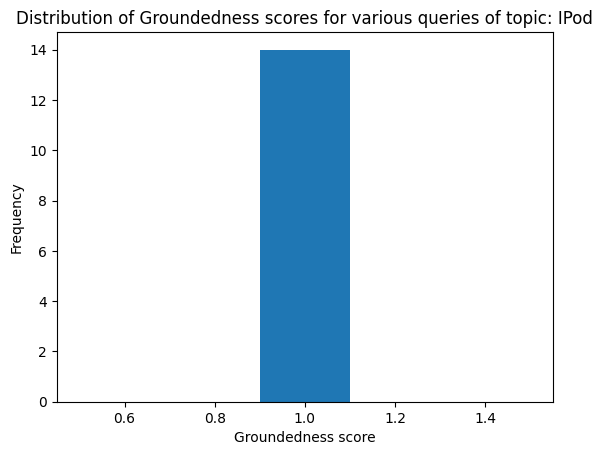

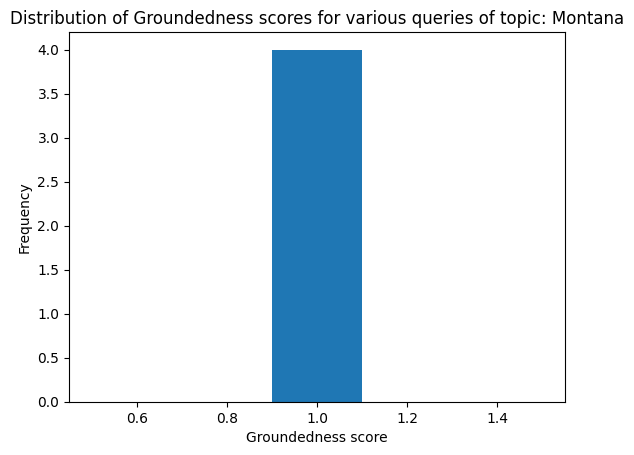

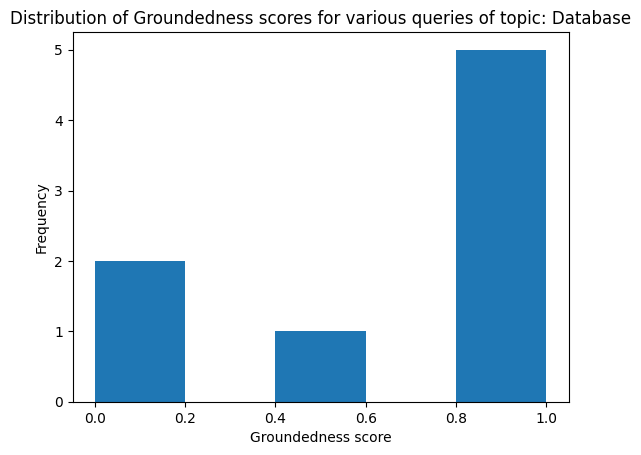

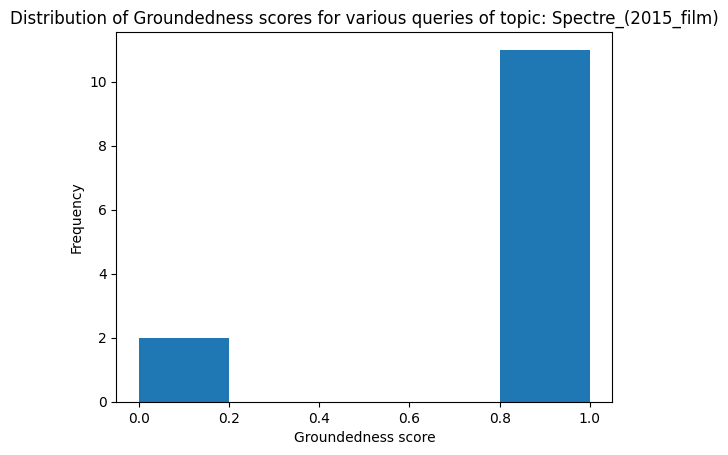

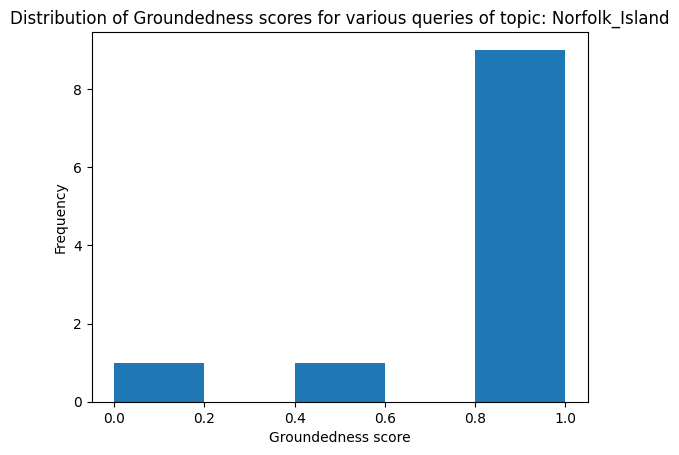

In [32]:
#plots a histogram of Groundedness scores for each topic
import matplotlib.pyplot as plt
for key in groundedness_dict:
    plt.hist(groundedness_dict[key], bins = 5)
    plt.title(f"Distribution of Groundedness scores for various queries of topic: {key}")
    plt.xlabel('Groundedness score')
    plt.ylabel('Frequency')
    plt.show()

In [33]:
#tells us the % of queries of a topic that were failing on groundedness - should match up with website
bad_groundedness = {key: 0 for key in groundedness_dict}
for key in groundedness_dict:
    values_list = groundedness_dict[key]
    counter = 0
    for value in values_list:
        if value < 0.6:
            counter += 1
    bad_groundedness[key] = counter/len(values_list)
bad_groundedness

{'IPod': 0.0,
 'Montana': 0.0,
 'Database': 0.375,
 'Spectre_(2015_film)': 0.15384615384615385,
 'Norfolk_Island': 0.18181818181818182}